# Assignment:-


## Apply SVM to Amazon Reviews data set

## Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# 1. Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). Use BoW, TF-IDF, Avg-Word2Vec,TF-IDF-Word2Vec to vectorise the reviews. 
Apply RBFSVM Algorithm for Amazon fine food Reviews
find right C, gamma(ɣ)  where ɣ=1/c  by Gridsearch cv,Random search cv

In [1]:
# loading required libraries 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import gensim
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


## 1.1 Connecting SQL file

In [2]:
#Loading the data
con = sqlite3.connect('./final.sqlite')

data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [3]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## 1.2 Data Preprocessing

In [4]:
data.Score.value_counts()
#i had done data preprocessing i had stored in final.sqlite now loaded this file no need to do again data preprocessing


positive    307061
negative     57110
Name: Score, dtype: int64

## 1.3 Sorting the data


In [5]:
# Sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.4 Mapping

In [6]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative
sorted_data.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.5 Taking first 140k rows

In [7]:
# We will collect different 140000 rows without repetition from time_sorted_data dataframe
my_final = sorted_data[:140000]
print(my_final.shape)
my_final.head()

(140000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.6 Spliting data into train and test based on time (70:30)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


x=my_final['CleanedText'].values
y=my_final['Score']

#Splitting data into train test and cross validation 
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size =0.3,random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(98000,)
(42000,)
(98000,)
(42000,)


## 2.  Techniques For Vectorization

## Why we have to convert text to vector
By converting text to vector we can use whole power of linear algebra.we can find a plane to seperate

## 2.1 BOW

In [9]:
#Bow

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
final_counts_Bow_tr= count_vect.fit_transform(x_train)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_tr))
print("the shape of out text BOW vectorizer ",final_counts_Bow_tr.get_shape())
print("the number of unique words ", final_counts_Bow_tr.get_shape()[1])
final_counts_Bow_test= count_vect.transform(x_test)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_test))
print("the shape of out text BOW vectorizer ",final_counts_Bow_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (98000, 36949)
the number of unique words  36949
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (42000, 36949)


## 2.1.1 Normalizing Data 

In [10]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_Bow_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_Bow_test)
print(standardized_data_test.shape)


(98000, 36949)
(42000, 36949)


## 2.2 Applying Support vector Machine Algorithm


## 2.2.1 Applying SGD Classifier by GridSearchCV

In [11]:
from sklearn import linear_model
clf=linear_model.SGDClassifier(loss='hinge',max_iter=1000,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = GridSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_alpha = a.get('alpha')

best alpha value is SGDClassifier(alpha=10, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.93


In [12]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.88689402, 0.8288472 , 0.84536848, 0.90860996, 0.92785445])

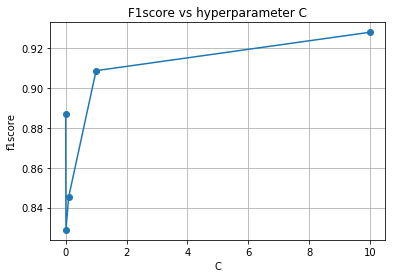

In [13]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [14]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 2.3 Confusion Matrix

Confusion Matrix:


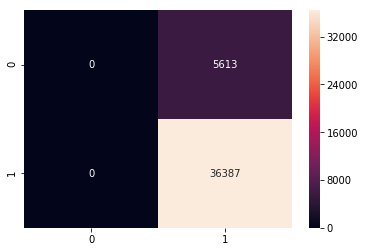

In [15]:
cm_bow=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [16]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 0 
 false positives are 5613 
 false negatives are 0
 true positives are 36387 
 


## 2.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [17]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# evaluating accuracy
acc_bow = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for alpha = %.3f is %f%%' % (optimal_alpha, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error SVM for alpha  is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the  SVM for alpha  = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the  SVM for alpha  = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the  SVM for alpha  \n\n ',(classification_report))



The Test Accuracy of the SVM for alpha = 10.000 is 86.635714%

Test Error SVM for alpha  is  13.364286%

The Test Precision of the  SVM for alpha  = 10.000 is 0.866357

The Test Recall of the  SVM for alpha  = 10.000 is 1.000000

The Test classification report of the  SVM for alpha  

                precision    recall  f1-score   support

           0       0.00      0.00      0.00      5613
           1       0.87      1.00      0.93     36387

   micro avg       0.87      0.87      0.87     42000
   macro avg       0.43      0.50      0.46     42000
weighted avg       0.75      0.87      0.80     42000



## 2.5 Plotting roc_auc curve

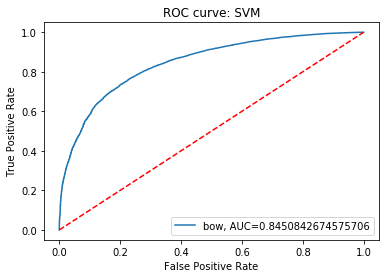

In [18]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="bow, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.6 Top 25 words 

In [19]:
top_n=25
# sorting the weight indices 
pos_class_weight_sorted = -clf.coef_.argsort()
neg_class_weight_sorted = clf.coef_.argsort()
            
# top positive features 
print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
pos = np.take(count_vect.get_feature_names(), pos_class_weight_sorted[:top_n])
for i in range(top_n):
    print(pos[0][i])

# top negative features
print('\n Top '+str(top_n)+' "NEGATIVE" Features are:\n')
neg = np.take(count_vect.get_feature_names(), neg_class_weight_sorted[:top_n])
for i in range(top_n):
    print(neg[0][i])


Top 25 "POSITIVE" Features are:

cardo
feldman
airforc
salesperson
leukemia
vacumn
tourist
indegst
groundbal
dump
satat
rood
entendr
theoriz
bunchi
methion
racquetbal
vegey
traditon
apper
costom
duplo
lat
extrins
goooooooooo

 Top 25 "NEGATIVE" Features are:

tast
product
would
disappoint
like
bad
box
money
order
review
didnt
dont
receiv
buy
thought
item
even
away
bought
wast
smell
return
look
purchas
packag


(-0.5, 2999.5, 2499.5, -0.5)

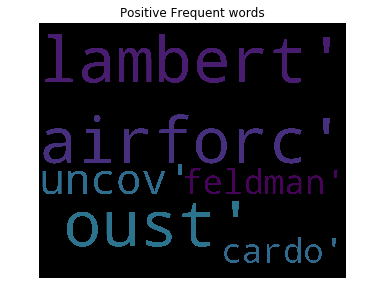

In [20]:
pos=''.join(str(e) for e in pos)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(pos)

plt.title("Positive Frequent words")
plt.figure(1, figsize=(25, 25))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')

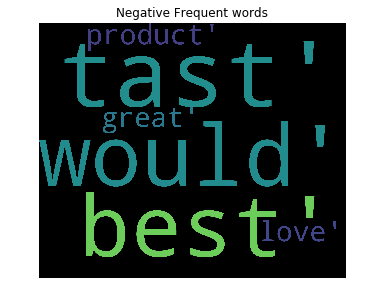

In [21]:
neg=''.join(str(e) for e in neg)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neg)

plt.title("Negative Frequent words")
plt.figure(1, figsize=(25, 25))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## 2.7 Applying SGD Classifier by RandomizedSearchCV

In [22]:
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
clf=linear_model.SGDClassifier(loss='hinge',max_iter=100,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = RandomizedSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_alpha = a.get('alpha')

best alpha value is SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.59


In [23]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.88700749, 0.8221228 , 0.90384401, 0.61870315, 0.62309491])

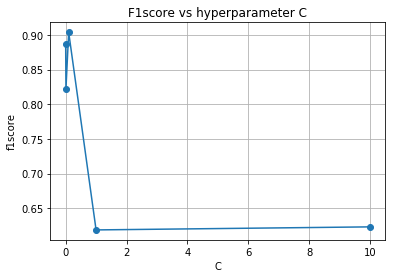

In [24]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [25]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 2.8 Confusion Matrix

Confusion Matrix:


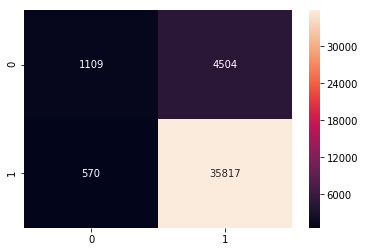

In [26]:
cm_bow=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [27]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1109 
 false positives are 4504 
 false negatives are 570
 true positives are 35817 
 


## 2.9 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [28]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# evaluating accuracy
acc_bow = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for alpha = %.3f is %f%%' % (optimal_alpha, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error SVM for alpha  is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the  SVM for alpha  = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the  SVM for alpha  = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the  SVM for alpha  \n\n ',(classification_report))



The Test Accuracy of the SVM for alpha = 0.100 is 87.919048%

Test Error SVM for alpha  is  12.080952%

The Test Precision of the  SVM for alpha  = 0.100 is 0.888296

The Test Recall of the  SVM for alpha  = 0.100 is 0.984335

The Test classification report of the  SVM for alpha  

                precision    recall  f1-score   support

           0       0.66      0.20      0.30      5613
           1       0.89      0.98      0.93     36387

   micro avg       0.88      0.88      0.88     42000
   macro avg       0.77      0.59      0.62     42000
weighted avg       0.86      0.88      0.85     42000



## 2.10 Plotting roc_auc curve

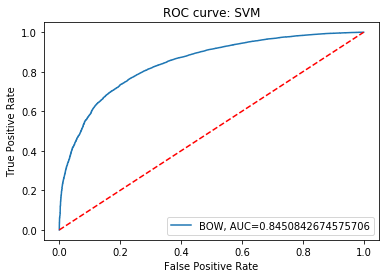

In [29]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="BOW, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.11 Top 25 words 

In [30]:
top_n=25
# sorting the weight indices 
pos_class_weight_sorted = -clf.coef_.argsort()
neg_class_weight_sorted = clf.coef_.argsort()
            
# top positive features 
print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
pos = np.take(count_vect.get_feature_names(), pos_class_weight_sorted[:top_n])
for i in range(top_n):
    print(pos[0][i])

# top negative features
print('\nTop '+str(top_n)+' "NEGATIVE" Features are:\n')
neg = np.take(count_vect.get_feature_names(), neg_class_weight_sorted[:top_n])
for i in range(top_n):
    print(neg[0][i])


Top 25 "POSITIVE" Features are:

cardo
feldman
airforc
salesperson
leukemia
vacumn
tourist
indegst
groundbal
dump
satat
rood
entendr
theoriz
bunchi
methion
racquetbal
vegey
traditon
apper
costom
duplo
lat
extrins
goooooooooo

Top 25 "NEGATIVE" Features are:

tast
product
would
disappoint
like
bad
box
money
order
review
didnt
dont
receiv
buy
thought
item
even
away
bought
wast
smell
return
look
purchas
packag


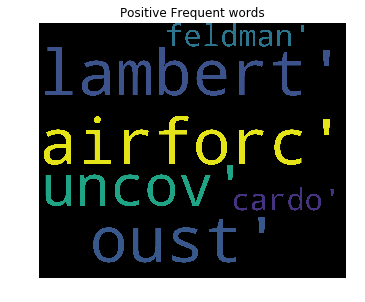

In [31]:
pos=''.join(str(e) for e in pos)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(pos)

plt.title("Positive Frequent words")
plt.figure(1, figsize=(25, 25))
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

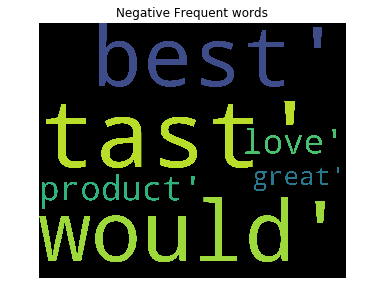

In [32]:
neg=''.join(str(e) for e in neg)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neg)

plt.title("Negative Frequent words")
plt.figure(1, figsize=(25, 25))
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 3. Applying RBF Kernel for Grid Search

(98000, 36949)


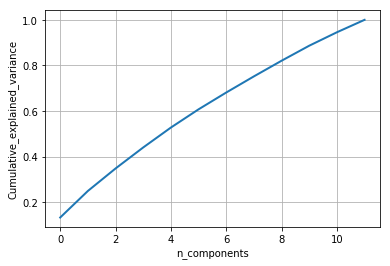

In [33]:
# PCA for dimensionality redcution (non-visualization)
# initializing the pca
from scipy.sparse import csr_matrix
from sklearn import decomposition
pca = decomposition.PCA()

standardized_data_train = csr_matrix(standardized_data_train)
standardized_data_train=standardized_data_train.todense()
print(standardized_data_train.shape)

pca.n_components = 12
pca_data = pca.fit_transform(standardized_data_train)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 9-dimensions, approx. 90% of variance is expalined.

In [34]:
from sklearn.decomposition import TruncatedSVD
final_counts_Bow_tr_svd = TruncatedSVD(n_components=9).fit_transform(final_counts_Bow_tr)
final_counts_Bow_tr_svd1 = TruncatedSVD(n_components=9).fit_transform(final_counts_Bow_test)

## 3.1 Normalizing data

In [35]:
# Data-preprocessing: Normalizing the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_data_train = scaler.fit_transform(final_counts_Bow_tr_svd)
print(standardized_data_train.shape)
standardized_data_test = scaler.fit_transform(final_counts_Bow_tr_svd1)
print(standardized_data_test.shape)

(98000, 9)
(42000, 9)


In [36]:
#in RBF SVC hyper parameters are C,gamma

from sklearn.svm import SVC
clf=SVC(kernel='rbf',max_iter=1000,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = GridSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')

tunded parameters SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.86


In [37]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.1349898 , 0.13471429, 0.13539796, 0.13463265, 0.13465306,
       0.13458163, 0.13458163, 0.13458163, 0.23387755, 0.16611224,
       0.18035714, 0.40207143, 0.14154082, 0.37833673, 0.13458163,
       0.13458163, 0.52967347, 0.32055102, 0.32739796, 0.20494898,
       0.85543878, 0.1422551 , 0.37833673, 0.23515306, 0.8247449 ,
       0.78909184, 0.60739796, 0.45688776, 0.39834694, 0.85214286,
       0.1422551 , 0.37833673, 0.85440816, 0.84982653, 0.74642

In [38]:
y_pred = model.predict(standardized_data_test)

## 3.2 Confusion Matrix


Confusion Matrix:


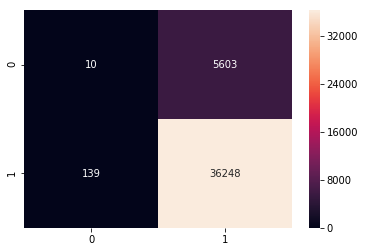

In [39]:
cm_bow=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [40]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negatives are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negatives are 10 
 false positives are 5603 
 false negatives are 139
 true positives are 36248 
 


## 3.3 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [41]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# evaluating accuracy
acc_bow = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM using RBF kernel  for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error SVM using RBF for alpha  is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the  SVM using RBF kernel  for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the  SVM using RBF kernel  for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the  SVM using RBF kernel  for C and gamma  \n\n ',(classification_report))


The Test Accuracy of the SVM using RBF kernel  for C and gamma = 100.000 ,100.000 is 86.328571%

Test Error SVM using RBF for alpha  is  13.671429%

The Test Precision of the  SVM using RBF kernel  for C and gamma = 100.000 ,100.000 is 0.866120

The Test Recall of the  SVM using RBF kernel  for C and gamma = 100.000 ,100.000 is 0.996180

The Test classification report of the  SVM using RBF kernel  for C and gamma  

                precision    recall  f1-score   support

           0       0.07      0.00      0.00      5613
           1       0.87      1.00      0.93     36387

   micro avg       0.86      0.86      0.86     42000
   macro avg       0.47      0.50      0.47     42000
weighted avg       0.76      0.86      0.80     42000



##  3.5 Applying RBF Kernel for Random Search

In [42]:
#in RBF SVC hyper parameters are C,gamma
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
clf=SVC(kernel='rbf',max_iter=100,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')

tunded parameters SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.82


In [43]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.3782551 , 0.13458163, 0.13458163, 0.13656122, 0.13458163,
       0.13458163, 0.13459184, 0.61404082, 0.25685714, 0.13458163])

In [44]:
y_pred = model.predict(standardized_data_test)

## 3.6 Confusion Matrix

Confusion Matrix:


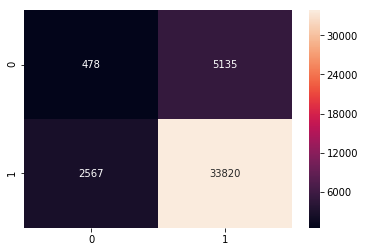

 true negitves are 478 
 false positives are 5135 
 false negatives are 2567
 true positives are 33820 
 


In [45]:
cm_bow=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

## 3.7 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [46]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# evaluating accuracy
acc_bow = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM using RBF kernel  for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error SVM using RBF  for C and gamma is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the  SVM using RBF kernel  for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the  SVM using RBF kernel  for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the  SVM using RBF kernel  for C and gamma \n\n ',(classification_report))


The Test Accuracy of the SVM using RBF kernel  for C and gamma = 100.000 ,0.010 is 81.661905%

Test Error SVM using RBF  for C and gamma is  18.338095%

The Test Precision of the  SVM using RBF kernel  for C and gamma = 100.000 ,0.010 is 0.868181

The Test Recall of the  SVM using RBF kernel  for C and gamma = 100.000 ,0.010 is 0.929453

The Test classification report of the  SVM using RBF kernel  for C and gamma 

                precision    recall  f1-score   support

           0       0.16      0.09      0.11      5613
           1       0.87      0.93      0.90     36387

   micro avg       0.82      0.82      0.82     42000
   macro avg       0.51      0.51      0.50     42000
weighted avg       0.77      0.82      0.79     42000



## 4. TF-IDF

In [47]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()

final_counts_tfidf_tr= tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(final_counts_tfidf_tr))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_tr.get_shape())
print("the number of unique words ", final_counts_tfidf_tr.get_shape()[1])
final_counts_tfidf_test= tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_tfidf_test))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_test.get_shape())
print("the number of unique words ", final_counts_tfidf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (98000, 36949)
the number of unique words  36949
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (42000, 36949)
the number of unique words  36949


## 4.1 Normalizing Data


In [48]:
# Data-preprocessing: Normalizing Data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_test)
print(standardized_data_test.shape)


(98000, 36949)
(42000, 36949)


## 4.2 Applying SGD Classifier by GridSearchCV

In [49]:
from sklearn import linear_model
clf=linear_model.SGDClassifier(loss='hinge',penalty='l2',max_iter=100,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = GridSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_alpha = a.get('alpha')


best alpha value is SGDClassifier(alpha=10, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.93


In [50]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.9033876 , 0.85983735, 0.56603207, 0.62378565, 0.92785445])

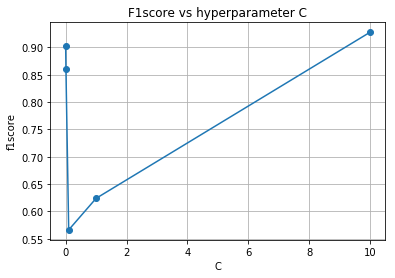

In [51]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [52]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 4.3 Confusion Matrix

Confusion Matrix:


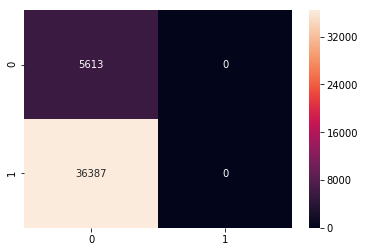

In [53]:
cm_tfidf=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

In [54]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5613 
 false positives are 0 
 false negatives are 36387
 true positives are 0 
 


## 4.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report


In [55]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for alpha = %.3f is %f%%' % (optimal_alpha, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error of the SVM for alpha is  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for alpha is = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for alpha is = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report oof the SVM for alpha is \n\n ',(classification_report))



The Test Accuracy of the SVM for alpha = 10.000 is 13.364286%

Test Error of the SVM for alpha is  86.635714%

The Test Precision of the SVM for alpha is = 10.000 is 0.000000

The Test Recall of the SVM for alpha is = 10.000 is 0.000000

The Test classification report oof the SVM for alpha is 

                precision    recall  f1-score   support

           0       0.13      1.00      0.24      5613
           1       0.00      0.00      0.00     36387

   micro avg       0.13      0.13      0.13     42000
   macro avg       0.07      0.50      0.12     42000
weighted avg       0.02      0.13      0.03     42000



## 4.5 Plotting roc_auc curve

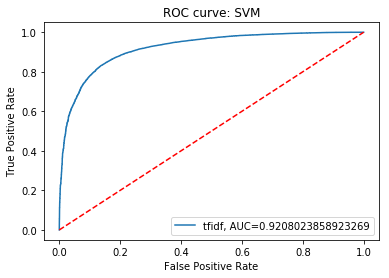

In [56]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="tfidf, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4.6 Top 25 words 

In [57]:
top_n=25
# sorting the weight indices 
pos_class_weight_sorted = -clf.coef_.argsort()
neg_class_weight_sorted = clf.coef_.argsort()
            
# top positive features 
print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
pos = np.take(tf_idf_vect.get_feature_names(), pos_class_weight_sorted[:top_n])
for i in range(top_n):
    print(pos[0][i])

# top negative features
print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
neg = np.take(tf_idf_vect.get_feature_names(), neg_class_weight_sorted[:top_n])
for i in range(top_n):
    print(neg[0][i])


Top 25 "POSITIVE" Features are:

salesperson
cardo
vacumn
airforc
indegst
feldman
tourist
satat
apper
duplo
entendr
bunchi
dump
ncieli
leukemia
vegey
methion
caleri
cnat
ajanta
vegitarian
costom
groundbal
bulldog
rood
Top 25 "NEGATIVE" Features are:

disappoint
tast
bad
would
money
product
box
didnt
wast
return
receiv
thought
review
horribl
like
away
item
terribl
stale
worst
aw
smell
order
threw
dont


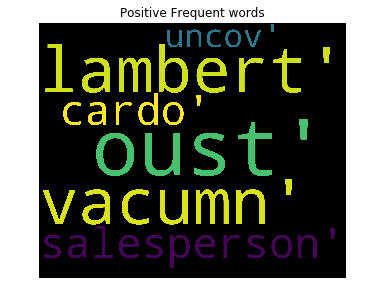

In [58]:
pos=''.join(str(e) for e in pos)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(pos)

plt.title("Positive Frequent words")
plt.figure(1, figsize=(25, 25))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

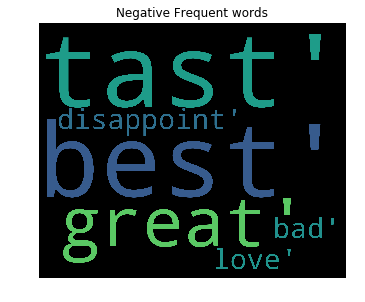

In [59]:
neg=''.join(str(e) for e in neg)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neg)

plt.title("Negative Frequent words")
plt.figure(1, figsize=(25, 25))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## 4.7 Applying SGD Classifier by RandomizedSearchCV

In [60]:
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
clf=linear_model.SGDClassifier(loss='hinge',penalty='l2',max_iter=100,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = RandomizedSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_alpha = a.get('alpha')

best alpha value is SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.90


In [61]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.90338307, 0.93630681, 0.74768332, 0.9296187 , 0.61857452])

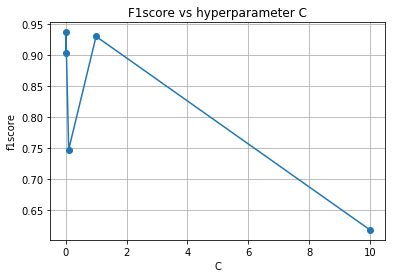

In [62]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [63]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 4.8 Confusion Matrix

Confusion Matrix:


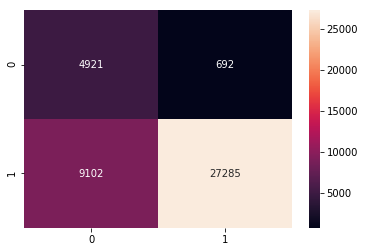

 true negitves are 4921 
 false positives are 692 
 false negatives are 9102
 true positives are 27285 
 


In [64]:
cm_tfidf=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

## 4.9 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [65]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for alpha = %.3f is %f%%' % (optimal_alpha, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error of the SVM for alpha is  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for alpha is = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for alpha is = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report oof the SVM for alpha is \n\n ',(classification_report))



The Test Accuracy of the SVM for alpha = 0.010 is 76.680952%

Test Error of the SVM for alpha is  23.319048%

The Test Precision of the SVM for alpha is = 0.010 is 0.975265

The Test Recall of the SVM for alpha is = 0.010 is 0.749856

The Test classification report oof the SVM for alpha is 

                precision    recall  f1-score   support

           0       0.35      0.88      0.50      5613
           1       0.98      0.75      0.85     36387

   micro avg       0.77      0.77      0.77     42000
   macro avg       0.66      0.81      0.67     42000
weighted avg       0.89      0.77      0.80     42000



## 4.10 Plotting Roc_auc score

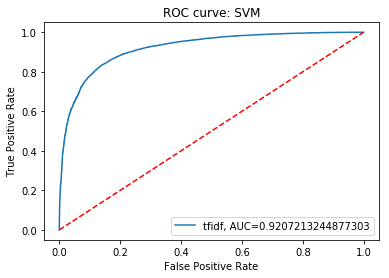

In [66]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="tfidf, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4.11 Calculating Top25 features

In [67]:
top_n=25
# sorting the weight indices 
pos_class_weight_sorted = -clf.coef_.argsort()
neg_class_weight_sorted = clf.coef_.argsort()
            
# top positive features 
print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
pos = np.take(tf_idf_vect.get_feature_names(), pos_class_weight_sorted[:top_n])
for i in range(top_n):
    print(pos[0][i])

# top negative features
print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
neg = np.take(tf_idf_vect.get_feature_names(), neg_class_weight_sorted[:top_n])
for i in range(top_n):
    print(neg[0][i])


Top 25 "POSITIVE" Features are:

salesperson
cardo
vacumn
airforc
indegst
feldman
tourist
satat
apper
duplo
entendr
bunchi
dump
ncieli
leukemia
vegey
methion
caleri
cnat
ajanta
vegitarian
costom
groundbal
bulldog
rood
Top 25 "NEGATIVE" Features are:

disappoint
tast
bad
would
money
product
box
didnt
wast
return
receiv
thought
review
horribl
like
away
item
terribl
stale
worst
aw
smell
order
threw
dont


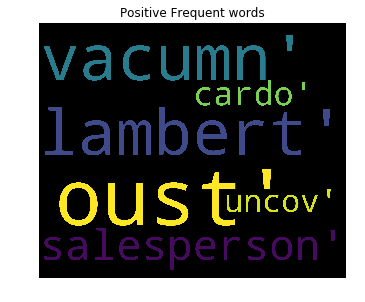

In [68]:
pos=''.join(str(e) for e in pos)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(pos)

plt.title("Positive Frequent words")
plt.figure(1, figsize=(25, 25))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

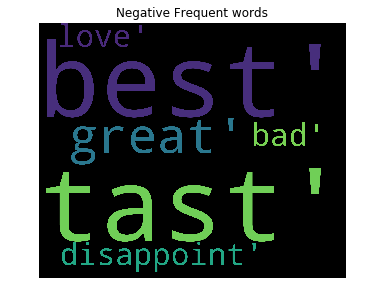

In [69]:
neg=''.join(str(e) for e in neg)

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neg)

plt.title("Negative Frequent words")
plt.figure(1, figsize=(25, 25))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## 5. Applying RBF Kernel for GridSearch

(98000, 36949)


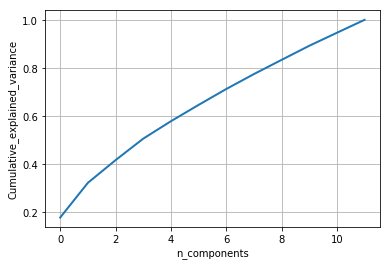

In [70]:
# PCA for dimensionality redcution (non-visualization)
# initializing the pca
from scipy.sparse import csr_matrix
from sklearn import decomposition
pca = decomposition.PCA()

standardized_data_train = csr_matrix(standardized_data_train)
standardized_data_train=standardized_data_train.todense()
print(standardized_data_train.shape)

pca.n_components = 12
pca_data = pca.fit_transform(standardized_data_train)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 9-dimensions, approx. 90% of variance is expalined.

In [71]:
from sklearn.decomposition import TruncatedSVD
final_counts_tfidf_tr_svd = TruncatedSVD(n_components=9).fit_transform(final_counts_tfidf_tr)
final_counts_tfidf_tr_svd1 = TruncatedSVD(n_components=9).fit_transform(final_counts_tfidf_test)

## 5.1 Normalizing data

In [72]:
# Data-preprocessing: Normalizing data 

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_tr_svd)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_tr_svd1)
print(standardized_data_test.shape)


(98000, 9)
(42000, 9)


In [73]:
#In RBF SVC hyper parameters are C,gamma
from sklearn.svm import SVC
clf=SVC(kernel='rbf',max_iter=100,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = GridSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')


tunded parameters SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.87


In [74]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13459184,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.14833673,
       0.14679592, 0.38522449, 0.86513265, 0.62186735, 0.13458163,
       0.13458163, 0.13458163, 0.16477551, 0.37640816, 0.38668367,
       0.37715306, 0.86513265, 0.62186735, 0.13458163, 0.13458163,
       0.17866327, 0.57082653, 0.31285714, 0.18407143, 0.37715306,
       0.86513265, 0.62186735, 0.13458163, 0.24285714, 0.46761

In [75]:
y_pred = model.predict(standardized_data_test)

## 5.2 Confusion Matrix


Confusion Matrix:


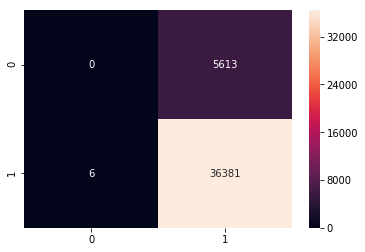

In [76]:
cm_tfidf=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

In [77]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 0 
 false positives are 5613 
 false negatives are 6
 true positives are 36381 
 


## 5.3 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [78]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error of the SVM for alpha  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for C and gamma \n\n ',(classification_report))




The Test Accuracy of the SVM for C and gamma = 10.000 ,1000.000 is 86.621429%

Test Error of the SVM for alpha  13.378571%

The Test Precision of the SVM for C and gamma = 10.000 ,1000.000 is 0.866338

The Test Recall of the SVM for C and gamma = 10.000 ,1000.000 is 0.999835

The Test classification report of the SVM for C and gamma 

                precision    recall  f1-score   support

           0       0.00      0.00      0.00      5613
           1       0.87      1.00      0.93     36387

   micro avg       0.87      0.87      0.87     42000
   macro avg       0.43      0.50      0.46     42000
weighted avg       0.75      0.87      0.80     42000



## 5.5 Applying RBF Kernel for RandomizedSearchCV

In [79]:
#In RBF SVC hyper parameters are C,gamma
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
clf=SVC(kernel='rbf',probability=True,max_iter=100,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')

tunded parameters SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=100, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.87


In [80]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.86513265, 0.13458163, 0.31285714, 0.13458163, 0.37715306,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.31285714])

In [81]:
y_pred = model.predict(standardized_data_test)

## 5.6 Confusion Matrix

Confusion Matrix:


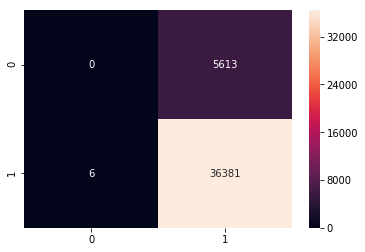

In [82]:
cm_tfidf=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

In [83]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 0 
 false positives are 5613 
 false negatives are 6
 true positives are 36381 
 


## 5.7 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [84]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error of the SVM for C and gamma %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for alpha \n\n ',(classification_report))


The Test Accuracy of the SVM for C and gamma = 10.000 ,1000.000 is 86.621429%

Test Error of the SVM for C and gamma 13.378571%

The Test Precision of the SVM for C and gamma = 10.000 ,1000.000 is 0.866338

The Test Recall of the SVM for C and gamma = 10.000 ,1000.000 is 0.999835

The Test classification report of the SVM for alpha 

                precision    recall  f1-score   support

           0       0.00      0.00      0.00      5613
           1       0.87      1.00      0.93     36387

   micro avg       0.87      0.87      0.87     42000
   macro avg       0.43      0.50      0.46     42000
weighted avg       0.75      0.87      0.80     42000



## 6. WORD2VEC

In [85]:
from gensim.models import Word2Vec
# List of sentence in X_train text
sent_of_train=[]
for sent in x_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in x_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  12448


## 7. Avg Word2Vec

In [86]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

## 7.1 Normalizing data

In [87]:
# Data-preprocessing: Normalizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(train_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(test_vectors)
print(standardized_data_test.shape)

(98000, 50)
(42000, 50)


## 7.2 Applying SGD Classifier by GridSearchCV

In [88]:
from sklearn import linear_model
clf=linear_model.SGDClassifier(loss='hinge',max_iter=100,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = GridSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
optimal_alpha = model.best_estimator_.alpha
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))

a = model.best_params_
optimal_alpha = a.get('alpha')



best alpha value is SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.80


In [89]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.88198769, 0.87344031, 0.92292503, 0.30927993, 0.61855987])

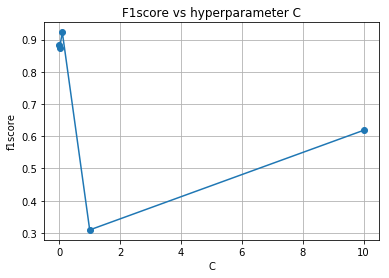

In [90]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [91]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 7.3 Confusion Matrix

Confusion Matrix:


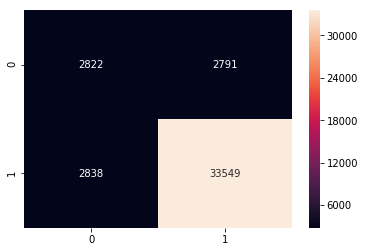

In [92]:
cm_avgw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [93]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 2822 
 false positives are 2791 
 false negatives are 2838
 true positives are 33549 
 


## 7.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [94]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for alpha is = %.3f is %f%%' % (optimal_alpha, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error of the SVM for alpha is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for alpha is = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for alpha is = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for alpha is \n\n ',(classification_report))



The Test Accuracy of the SVM for alpha is = 0.100 is 86.597619%

Test Error of the SVM for alpha is  13.402381%

The Test Precision of the SVM for alpha is = 0.100 is 0.923198

The Test Recall of the SVM for alpha is = 0.100 is 0.922005

The Test classification report of the SVM for alpha is 

                precision    recall  f1-score   support

           0       0.50      0.50      0.50      5613
           1       0.92      0.92      0.92     36387

   micro avg       0.87      0.87      0.87     42000
   macro avg       0.71      0.71      0.71     42000
weighted avg       0.87      0.87      0.87     42000



## 7.5 Evaluating roc_auc_score

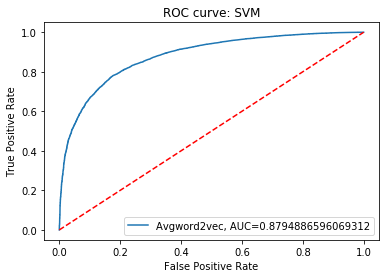

In [95]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Avgword2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 7.6 Applying SGD Classifier by RandomizedSearchCV

In [96]:
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
clf=linear_model.SGDClassifier(loss='hinge',max_iter=100,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = RandomizedSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
optimal_alpha = model.best_estimator_.alpha
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))

a = model.best_params_
optimal_alpha = a.get('alpha')

best alpha value is SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.88


In [97]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.88397563, 0.8735095 , 0.77390256, 0.61857452, 0.61857452])

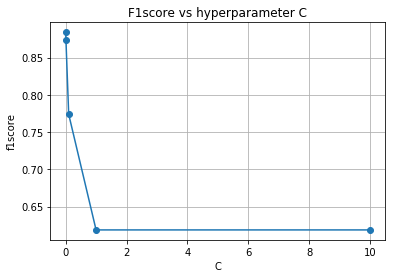

In [98]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [99]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 7.7 Confusion Matrix

Confusion Matrix:


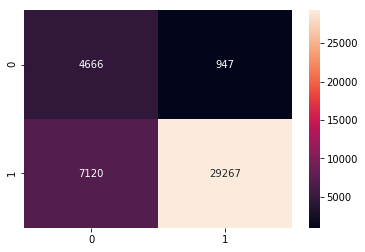

In [100]:
cm_avgw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [101]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4666 
 false positives are 947 
 false negatives are 7120
 true positives are 29267 
 


## 7.8 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [102]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for alpha is = %.3f is %f%%' % (optimal_alpha, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error of the SVM for alpha is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for alpha is = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for alpha is = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for alpha is \n\n ',(classification_report))


The Test Accuracy of the SVM for alpha is = 0.001 is 80.792857%

Test Error of the SVM for alpha is  19.207143%

The Test Precision of the SVM for alpha is = 0.001 is 0.968657

The Test Recall of the SVM for alpha is = 0.001 is 0.804326

The Test classification report of the SVM for alpha is 

                precision    recall  f1-score   support

           0       0.40      0.83      0.54      5613
           1       0.97      0.80      0.88     36387

   micro avg       0.81      0.81      0.81     42000
   macro avg       0.68      0.82      0.71     42000
weighted avg       0.89      0.81      0.83     42000



## 7.9 Plotting ROC CURVE

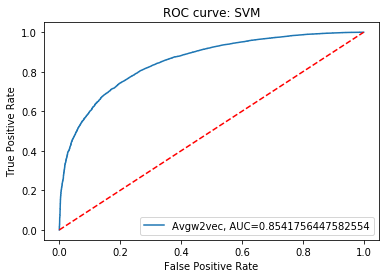

In [103]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Avgw2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 8. APPLYING RBF KERNEL BY GRIDSEARCH 

(98000, 50)


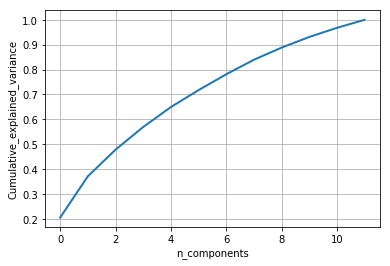

In [104]:
# PCA for dimensionality redcution (non-visualization)
# initializing the pca
from scipy.sparse import csr_matrix
from sklearn import decomposition
pca = decomposition.PCA()

standardized_data_train = csr_matrix(standardized_data_train)
standardized_data_train=standardized_data_train.todense()
print(standardized_data_train.shape)

pca.n_components = 12
pca_data = pca.fit_transform(standardized_data_train)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 9-dimensions, approx. 90% of variance is expalined.

In [105]:
from sklearn.decomposition import TruncatedSVD
final_counts_avg_w2v_svd = TruncatedSVD(n_components=9).fit_transform(train_vectors)
final_counts_avg_w2v_svd1 = TruncatedSVD(n_components=9).fit_transform(test_vectors)

## 8.2 Normalizing data

In [106]:
# Data-preprocessing:Normalizing data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_avg_w2v_svd)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_avg_w2v_svd1)
print(standardized_data_test.shape)

(98000, 9)
(42000, 9)


In [107]:
#In RBF SVC hyper parameters are C,gamma
from sklearn.svm import SVC
clf=SVC(kernel='rbf',max_iter=100,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = GridSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')


tunded parameters SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10000, kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.85


In [108]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13459184,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13971429,
       0.19752041, 0.14194898, 0.62153061, 0.84621429, 0.13458163,
       0.13458163, 0.13458163, 0.22086735, 0.47533673, 0.30638776,
       0.14194898, 0.62153061, 0.84621429, 0.13458163, 0.13458163,
       0.16184694, 0.47785714, 0.48837755, 0.30638776, 0.14194898,
       0.62153061, 0.84621429, 0.13458163, 0.16944898, 0.52169

In [109]:
y_pred = model.predict(standardized_data_test)

## 8.3 Confusion Matrix

Confusion Matrix:


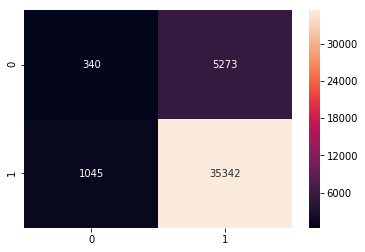

In [110]:
cm_avgw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [111]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 340 
 false positives are 5273 
 false negatives are 1045
 true positives are 35342 
 


## 8.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [112]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error of the SVM for C and gamma is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for C and gamma  is \n\n ',(classification_report))



The Test Accuracy of the SVM for C and gamma = 10.000 ,10000.000 is 84.957143%

Test Error of the SVM for C and gamma is  15.042857%

The Test Precision of the SVM for C and gamma = 10.000 ,10000.000 is 0.870171

The Test Recall of the SVM for C and gamma = 10.000 ,10000.000 is 0.971281

The Test classification report of the SVM for C and gamma  is 

                precision    recall  f1-score   support

           0       0.25      0.06      0.10      5613
           1       0.87      0.97      0.92     36387

   micro avg       0.85      0.85      0.85     42000
   macro avg       0.56      0.52      0.51     42000
weighted avg       0.79      0.85      0.81     42000



## 8.5 APPLYING RBF KERNEL BY RandomizedSearchCV 

In [113]:
#in RBF SVC hyper parameters are C,gamma
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

clf=SVC(kernel='rbf',max_iter=100,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')

tunded parameters SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.17


In [114]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.19752041, 0.14194898])

In [115]:
y_pred = model.predict(standardized_data_test)

## 8.6 Confusion Matrix

Confusion Matrix:


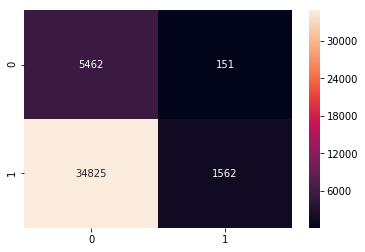

In [116]:
cm_avgw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [117]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5462 
 false positives are 151 
 false negatives are 34825
 true positives are 1562 
 


## 8.7 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [118]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error of the SVM for C and gamma is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for C and gamma \n\n ',(classification_report))


The Test Accuracy of the SVM for C and gamma = 10.000 ,10.000 is 16.723810%

Test Error of the SVM for C and gamma is  83.276190%

The Test Precision of the SVM for C and gamma = 10.000 ,10.000 is 0.911851

The Test Recall of the SVM for C and gamma = 10.000 ,10.000 is 0.042927

The Test classification report of the SVM for C and gamma 

                precision    recall  f1-score   support

           0       0.14      0.97      0.24      5613
           1       0.91      0.04      0.08     36387

   micro avg       0.17      0.17      0.17     42000
   macro avg       0.52      0.51      0.16     42000
weighted avg       0.81      0.17      0.10     42000



## 9. TFIDF-Word2Vec

In [119]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect = TfidfVectorizer()
final_counts_tfidfw2v_train= tfidfw2v_vect.fit_transform(x_train) 
print(type(final_counts_tfidfw2v_train))
print(final_counts_tfidfw2v_train.shape)

final_counts_tfidfw2v_test= tfidfw2v_vect.transform(x_test) 
print(type(final_counts_tfidfw2v_test))
print(final_counts_tfidfw2v_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(98000, 36949)
<class 'scipy.sparse.csr.csr_matrix'>
(42000, 36949)


In [120]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidfw2v_vect.get_feature_names(), list(tfidfw2v_vect.idf_)))


# TF-IDF weighted Word2Vec
tfidf_feat = tfidfw2v_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

#Test case

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors1))

98000
42000


## 9.1 Normalizing the data

In [121]:
# Data-preprocessing: Normalizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(tfidf_sent_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(tfidf_sent_vectors1)
print(standardized_data_test.shape)


(98000, 50)
(42000, 50)


## 9.2 Applying SGD Classifier Using GridSearch


In [122]:
from sklearn import linear_model
clf=linear_model.SGDClassifier(loss='hinge',penalty='l2',max_iter=100,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = GridSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
optimal_alpha = model.best_estimator_.alpha
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_alpha = a.get('alpha')


best alpha value is SGDClassifier(alpha=10, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.93


In [123]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.86897213, 0.8656872 , 0.75748986, 0.61855987, 0.91928743])

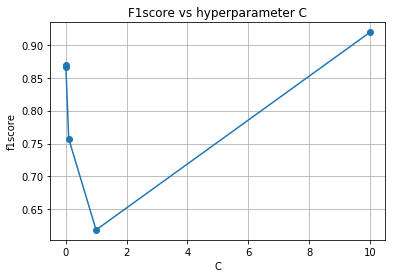

In [124]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [125]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 9.3 Confusion Matrix

Confusion Matrix:


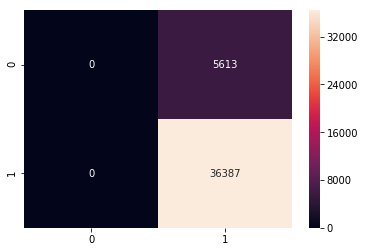

In [126]:
cm_tfidfw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [127]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 0 
 false positives are 5613 
 false negatives are 0
 true positives are 36387 
 


## 9.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [128]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM for alpha = %.3f is %f%%' % (optimal_alpha, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error of the SVM for alpha is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for alpha is = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for alpha is = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for alpha is \n\n ',(classification_report))


The Test Accuracy of the SVM for alpha = 10.000 is 86.635714%

Test Error of the SVM for alpha is  13.364286%

The Test Precision of the SVM for alpha is = 10.000 is 0.866357

The Test Recall of the SVM for alpha is = 10.000 is 1.000000

The Test classification report of the SVM for alpha is 

                precision    recall  f1-score   support

           0       0.00      0.00      0.00      5613
           1       0.87      1.00      0.93     36387

   micro avg       0.87      0.87      0.87     42000
   macro avg       0.43      0.50      0.46     42000
weighted avg       0.75      0.87      0.80     42000



## Evaluating roc_auc_score

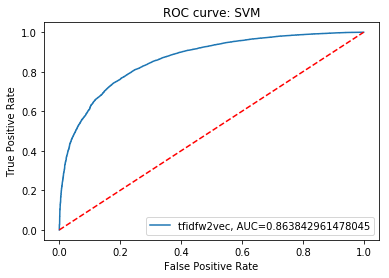

In [129]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="tfidfw2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 9.5 Applying SGD Classifier Using RandomizedSearchCV

In [130]:
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV

clf=linear_model.SGDClassifier(loss='hinge',penalty='l2',max_iter=100,class_weight='balanced')
tuned_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

model = RandomizedSearchCV(clf, tuned_parameters,cv=3,scoring='f1', n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("best alpha value is",model.best_estimator_)
optimal_alpha = model.best_estimator_.alpha
print("Accuracy of the model : {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_alpha = a.get('alpha')

best alpha value is SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model : 0.44


In [131]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.86976873, 0.8658434 , 0.87406185, 0.61857452, 0.61857452])

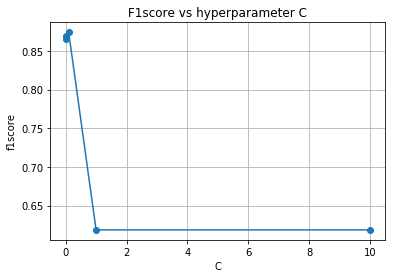

In [132]:
C=0.001, 0.01, 0.1, 1, 10
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [133]:
clf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_alpha,class_weight='balanced')
clf.fit(standardized_data_train,y_train)
y_pred = clf.predict(standardized_data_test)

## 9.6 Confusion Matrix

Confusion Matrix:


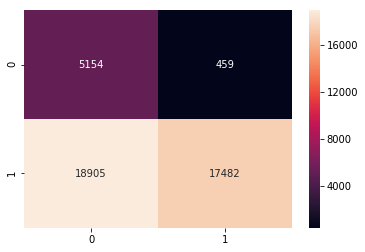

In [134]:
cm_tfidfw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [135]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5154 
 false positives are 459 
 false negatives are 18905
 true positives are 17482 
 


## 9.7 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [136]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the SVM classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error of the SVM for alpha is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the SVM for alpha is = %.3f is %f' % (optimal_alpha, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the SVM for alpha is = %.3f is %f' % (optimal_alpha, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the SVM for alpha is \n\n ',(classification_report))


The Test Accuracy of the SVM classifier for alpha = 0.100 is 53.895238%

Test Error of the SVM for alpha is  46.104762%

The Test Precision of the SVM for alpha is = 0.100 is 0.974416

The Test Recall of the SVM for alpha is = 0.100 is 0.480446

The Test classification report of the SVM for alpha is 

                precision    recall  f1-score   support

           0       0.21      0.92      0.35      5613
           1       0.97      0.48      0.64     36387

   micro avg       0.54      0.54      0.54     42000
   macro avg       0.59      0.70      0.50     42000
weighted avg       0.87      0.54      0.60     42000



## Evaluating Roc_auc_score

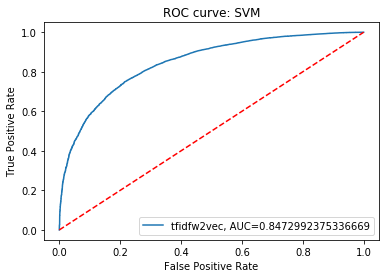

In [137]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated.fit(standardized_data_train, y_train)
y_pred_proba = calibrated.predict_proba(standardized_data_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="tfidfw2vec, AUC="+str(auc))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC curve: SVM')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 10. APPLYING RBF KERNEL BY GRID SEARCH

## 10.1 Gridsearch Cross Validation

(98000, 50)


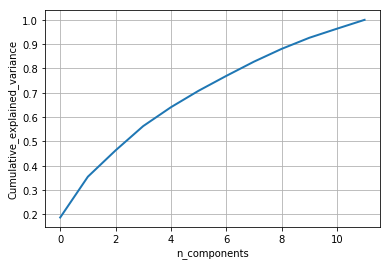

In [138]:
# PCA for dimensionality redcution (non-visualization)
# initializing the pca
from scipy.sparse import csr_matrix
from sklearn import decomposition
pca = decomposition.PCA()

standardized_data_train = csr_matrix(standardized_data_train)
standardized_data_train=standardized_data_train.todense()
print(standardized_data_train.shape)

pca.n_components = 12
pca_data = pca.fit_transform(standardized_data_train)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 9-dimensions, approx. 90% of variance is expalined.

In [139]:
from sklearn.decomposition import TruncatedSVD
final_counts_tfidf_w2v_svd = TruncatedSVD(n_components=9).fit_transform(tfidf_sent_vectors)
final_counts_tfidf_w2v_svd1 = TruncatedSVD(n_components=9).fit_transform(tfidf_sent_vectors1)

## 10.2 Normalizing the data

In [140]:
# Data-preprocessing: Normalizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_w2v_svd)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_w2v_svd1)
print(standardized_data_test.shape)

(98000, 9)
(42000, 9)


In [141]:
#in RBF SVC hyper parameters are C,gamma 
from sklearn.svm import SVC
clf=SVC(kernel='rbf',max_iter=100,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = GridSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')


tunded parameters SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10000, kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.86


In [142]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163,
       0.13458163, 0.13458163, 0.13459184, 0.13459184, 0.13459184,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.137     ,
       0.17482653, 0.38171429, 0.38006122, 0.82792857, 0.13458163,
       0.13458163, 0.13458163, 0.14910204, 0.39130612, 0.40759184,
       0.38171429, 0.38006122, 0.82792857, 0.13458163, 0.13458163,
       0.15427551, 0.51593878, 0.35911224, 0.40759184, 0.38171429,
       0.38006122, 0.82792857, 0.13458163, 0.27632653, 0.53325

In [143]:
y_pred = model.predict(standardized_data_test)

## 10.3 Confusion Matrix

Confusion Matrix:


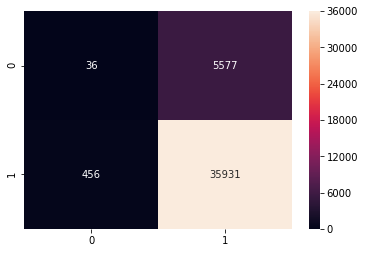

In [144]:
cm_tfidfw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [145]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 36 
 false positives are 5577 
 false negatives are 456
 true positives are 35931 
 


## 10.4 Calculating Accuracy, Error on test data,Precision,Recall,Classification Report

In [146]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the  SVM using RBF kernel for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error  of the  SVM using RBF kernel for C and gamma =   %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the  SVM using RBF kernel for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the  SVM using RBF kernel for C and gamma = %.3f ,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the  SVM using RBF kernel for alpha \n\n ',(classification_report))


The Test Accuracy of the  SVM using RBF kernel for C and gamma = 10.000 ,10000.000 is 85.635714%

Test Error  of the  SVM using RBF kernel for C and gamma =   14.364286%

The Test Precision of the  SVM using RBF kernel for C and gamma = 10.000 ,10000.000 is 0.865640

The Test Recall of the  SVM using RBF kernel for C and gamma = 10.000 ,10000.000 is 0.987468

The Test classification report of the  SVM using RBF kernel for alpha 

                precision    recall  f1-score   support

           0       0.07      0.01      0.01      5613
           1       0.87      0.99      0.92     36387

   micro avg       0.86      0.86      0.86     42000
   macro avg       0.47      0.50      0.47     42000
weighted avg       0.76      0.86      0.80     42000



## 10.5 APPLYING RBF KERNEL BY RandomizedSearchCV

In [147]:
#in RBF SVC hyper parameters are C,gamma 
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


clf=SVC(kernel='rbf',max_iter=100,class_weight='balanced')
tuned_parameters = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4],'gamma':[10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(clf, tuned_parameters,cv=3,n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("tunded parameters",model.best_estimator_)
print("Accuracy of model using SVC classifier by rbf kernel {:.2f}".format(model.score(standardized_data_test, y_test)))
a = model.best_params_
optimal_C = a.get('C')
optimal_gamma=a.get('gamma')

tunded parameters SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model using SVC classifier by rbf kernel 0.74


In [148]:
model.best_params_
results = model.cv_results_
results['mean_test_score']

array([0.13458163, 0.13458163, 0.40759184, 0.13458163, 0.13459184,
       0.13458163, 0.13458163, 0.13458163, 0.13458163, 0.13458163])

In [149]:
y_pred = model.predict(standardized_data_test)

## 10.6 Confusion Matrix

Confusion Matrix:


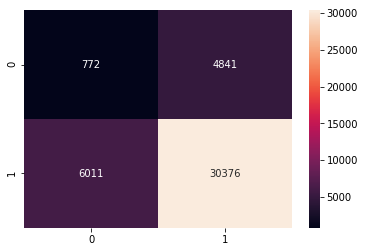

In [150]:
cm_tfidfw2v=confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [151]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 772 
 false positives are 4841 
 false negatives are 6011
 true positives are 30376 
 


## 10.7 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [152]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, y_pred) * 100
print('\nThe Test Accuracy of the  SVM using RBF kernel for C and gamma = %.3f ,%.3f is %f%%' % (optimal_C,optimal_gamma, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error  of the  SVM using RBF kernel for C and gamma  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, y_pred) 
print('\nThe Test Precision of the  SVM using RBF kernel for C and gamma = %.3f,%.3f is %f' % (optimal_C,optimal_gamma, precision_score))

# evaluating recall
recall_score = recall_score(y_test, y_pred)
print('\nThe Test Recall of the  SVM using RBF kernel for C and gamma = %.3f,%.3f is %f' % (optimal_C,optimal_gamma, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, y_pred)
print('\nThe Test classification report of the  SVM using RBF kernel for C and gamma \n\n ',(classification_report))


The Test Accuracy of the  SVM using RBF kernel for C and gamma = 100.000 ,10.000 is 74.161905%

Test Error  of the  SVM using RBF kernel for C and gamma  25.838095%

The Test Precision of the  SVM using RBF kernel for C and gamma = 100.000,10.000 is 0.862538

The Test Recall of the  SVM using RBF kernel for C and gamma = 100.000,10.000 is 0.834804

The Test classification report of the  SVM using RBF kernel for C and gamma 

                precision    recall  f1-score   support

           0       0.11      0.14      0.12      5613
           1       0.86      0.83      0.85     36387

   micro avg       0.74      0.74      0.74     42000
   macro avg       0.49      0.49      0.49     42000
weighted avg       0.76      0.74      0.75     42000



## 11. CONCLUSIONS:-

## Model performance table

-----------------------------------------------------------------------------------------------------
|                                            GRID SEARCH                                                   |

-----------------------------------------------------------------------------------------------------
|           Model         |        Hyper parameter(alpha)        | Test Error      |     Accuracy          |
|:-----------------------:|:------------------------------------:|:---------------:|:---------------------:|
| SGD with Bow            |              10                      |   13.364286     |      86.635714        |
| SGD with Tfidf          |              10                      |   13.364286     |      86.635714        |
| SGD with Avgw2v         |              0.100                   |   13.402381     |      86.597619        |
| SGD with Tfidfw2v       |              10                      |   13.364286     |      86.635714        |


------------------------------------------------------------------------------------------------------------
|           Model         |        Hyper parameter(alpha)        |    gamma     | Test Error   | Accuracy  |
|:-----------------------:|:------------------------------------:|:------------:|:------------:|:---------:|
| SVM with Bow            |              10                      |     1000     |13.671429     |86.328571  |
| SVM with Tfidf          |              10                      |     10000    |13.378571     |86.621429  |
| SVM with Avgw2v         |              10                      |     10000    |15.042857     |84.957143  |
| SVM with Tfidfw2v       |              10                      |     10000    |14.364286     |85.635714  |

------------------------------------------------------------------------------------------------------------
|                                            RANDOM SEARCH                                                 |

------------------------------------------------------------------------------------------------------------
|           Model         |        Hyper parameter(alpha)        | Test Error      |     Accuracy          |
|:-----------------------:|:------------------------------------:|:---------------:|:---------------------:|
| SGD with Bow            |              0.100                   |   12.080952     |      87.919048        |
| SGD with Tfidf          |              0.010                   |   23.319048     |      76.680952        |
| SGD with Avgw2v         |              0.001                   |   19.207143     |      80.792857        |
| SGD with Tfidfw2v       |              0.100                   |   46.104726     |      53.895238        |

------------------------------------------------------------------------------------------------------------
|           Model         |        Hyper parameter(alpha)        |    gamma     | Test Error   | Accuracy  |
|:-----------------------:|:------------------------------------:|:------------:|:------------:|:---------:|
| SVM with Bow            |              100                     |   0.010      |18.338095     |81.661905  |
| SVM with Tfidf          |              10                      |   1000       |13.378571     |86.621429  |
| SVM with Avgw2v         |              10                      |   10         |83.276190     |16.723810  |
| SVM with Tfidfw2v       |              100                     |   10         |25.838095     |74.161905  |

-----------------------------------------------------------------------------------------------------------------

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression 

challenges.Support Vectors are simply the co-ordinates of individual observation. Support Vector Machine is a frontier which 

best segregates the two classes (hyper-plane/ line).

SVM uses a technique called the kernel trick to transform your data and then based on these transformations it finds an optimal 

boundary between the possible outputs.

The function of kernel is to take data as input and transform it into the required form. Different SVM algorithms use different 

types of kernel functions. These functions can be different types. For example linear, nonlinear, polynomial, radial basis 

function (RBF), and sigmoid.

Steps Involved:-

1) Connecting SQL file

2) Data Preprocessing(Already i had done preprocessing no need to do again)

3) Sorting the data based on time

4) Taking 1st 150K Rows (Due to low Ram)

5) Spliting data into train and test based on time (70:30)

6) Techniques For Vectorization Bow,TF-IDF,word2vec,Avgword2vec,tfidfword2vec.

7) Normalizing Data 

8) Applying SGD CLASSIFIER For linear kernel using gridsearch and Random search 

9) I calculated Accuracy,Error on Test Data, Confusion Matrix,Precision Score,Recall Score,Classification Report,ROC_curve

10) Calculated top 25 Positive and Negative features

10) Applying SVC For RBF Kernel by gridsearch and Random search

11) I calculated Accuracy,Error on Test Data, Confusion Matrix,Precision Score,Recall Score,Classification Report,ROC_curve

12) Conclusion